## Capstone- Cancer Histopathology: Web App

Dataset:
- A. Borkowski, "Lung and Colon Cancer Histopathological Images", Kaggle.com, 2020. [Online]. Available: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images. [Accessed: 30- Jul- 2022].

Sources:
- Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019

Image Labels:
- Lung benign tissue: 3
- Lung adenocarcinoma: 2
- Lung squamous cell carcinoma: 4
- Colon adenocarcinoma: 0
- Colon benign tissue: 1

### Import Libraries

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
from pathlib import Path
import time
import math

# import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load Data

In [2]:
import PIL
from PIL import Image
import glob
import cv2
import os, os.path
from numpy import asarray

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from IPython.display import display, HTML
import pymongo
from pymongo import MongoClient
import io
from bson.binary import Binary

### Data Preprocessing

In [3]:
dataPath= "./lung_colon_image_set/lung_image_sets"
categories= os.listdir(dataPath)
labels= [i for i in range(len(categories))]
# empty dictionary
labelDict= dict(zip(categories, labels))

print(labelDict)
print(categories)
print(labels)

{'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}
['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
[0, 1, 2, 3, 4]


In [4]:
# %%time
# imgSize= 96
# data= []
# target= []
# tupleArr= []
# for category in categories:
#     folderPath= os.path.join(dataPath, category)
#     imgNames= os.listdir(folderPath)
    
#     for imgName in imgNames:
#         imgPath= os.path.join(folderPath, imgName)
#         img= cv2.imread(imgPath)
    
#         try:
#             resized= cv2.resize(img, (imgSize, imgSize))
#             data.append(resized)
#             target.append(labelDict[category])
#             tupleGrp= (resized, labelDict[category])
#             tupleArr.append(tupleGrp)
#         except Exception as e:
#             print('Exception:', e)

In [5]:
# np.save('data.npy', data)
# np.save('target.npy', target)
# np.save('tupleData.npy', tupleArr)

In [50]:
imageArr= np.load('data.npy')
targetArr= np.load('target.npy')
tupleData= np.load('tupleData.npy', allow_pickle= True)

In [7]:
# check Pillow version number
print('Pillow Version:', PIL.__version__)

Pillow Version: 9.1.0


In [8]:
# dfMergeData= pd.DataFrame(np.load('tupleData.npy', allow_pickle= True), columns=['imageVector', 'label'])
# dfMergeData.head()

In [9]:
# %%time
# dfData= dfMergeData.sample(frac=1).reset_index(drop= True)
# dfData.sample(10)

In [10]:
# dfArr= []
# for i in dfData.values:
#     dfArr.append(i)

In [11]:
# np.save('shuffledData.npy', dfArr)

In [12]:
dfShuffledData= pd.DataFrame(np.load('shuffledData.npy', allow_pickle= True),
                             columns=['imageVector', 'label'])
dfShuffledData.head()

,imageVector,label
0,"[[[213, 206, 219], [213, 206, 219], [210, 206,...",3
1,"[[[207, 207, 213], [208, 208, 214], [208, 208,...",3
2,"[[[187, 113, 176], [193, 109, 178], [200, 110,...",3
3,"[[[203, 120, 168], [187, 84, 123], [224, 160, ...",1
4,"[[[230, 199, 252], [238, 204, 251], [229, 190,...",0


In [13]:
dfShuffledData['label'].value_counts()

3    5000
1    5000
0    5000
4    5000
2    5000
Name: label, dtype: int64

In [14]:
def normalizeImage(image):
    imgVect= image/ 255.0
    return imgVect

In [15]:
dfShuffledData['scaledImage']= dfShuffledData['imageVector'].apply(normalizeImage)

In [16]:
dfShuffledData.head()

,imageVector,label,scaledImage
0,"[[[213, 206, 219], [213, 206, 219], [210, 206,...",3,"[[[0.8352941176470589, 0.807843137254902, 0.85..."
1,"[[[207, 207, 213], [208, 208, 214], [208, 208,...",3,"[[[0.8117647058823529, 0.8117647058823529, 0.8..."
2,"[[[187, 113, 176], [193, 109, 178], [200, 110,...",3,"[[[0.7333333333333333, 0.44313725490196076, 0...."
3,"[[[203, 120, 168], [187, 84, 123], [224, 160, ...",1,"[[[0.796078431372549, 0.47058823529411764, 0.6..."
4,"[[[230, 199, 252], [238, 204, 251], [229, 190,...",0,"[[[0.9019607843137255, 0.7803921568627451, 0.9..."


In [17]:
%%time
imgVectData= np.array(dfShuffledData['imageVector'].tolist())
imgVectData.shape

CPU times: total: 234 ms
Wall time: 236 ms


(25000, 96, 96, 3)

In [18]:
labelData= to_categorical(dfShuffledData['label'].values.reshape(25000, 1))
labelData.shape

(25000, 5)

In [53]:
from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasRegressor

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

In [62]:
def baseline_model02():
    # create model
    model= Sequential()
    model.add(layers.Conv2D(8, (3, 3), activation= 'relu', data_format= 'channels_last',
                            padding= 'valid' ,input_shape= (96, 96, 3)))
    model.add(layers.MaxPooling2D((5, 5)))
    model.add(layers.Conv2D(16, (3, 3), activation= 'relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(5, activation='softmax'))
    # Compile model
    model.compile(
        optimizer= 'adam',
        loss= 'categorical_crossentropy',
        metrics= ['accuracy'])
    return model

# evaluate model
clf= KerasClassifier(baseline_model02, validation_split= 0.3, epochs= 5, batch_size= 10, verbose= 1)

In [373]:
def baseline_model03():
    # create model
    model= Sequential()
#     model.add(layers.Conv2D(32, (1, 1), activation= 'relu', data_format= 'channels_last',
#                         padding= 'valid' ,input_shape= rzImageArr.shape[1:]))
    model.add(layers.Conv2D(32, (1, 1), activation= 'relu',input_shape= rzImageArr.shape[1:]))
    model.add(layers.Conv2D(32, (1, 1), activation= 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation= 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dropout(0.2))
    # model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dropout(0.2))
#     model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))
    # Compile model
    model.compile(
        optimizer= 'adam',
        loss= 'categorical_crossentropy',
        metrics= ['accuracy'])
    return model

# evaluate model
clf01= KerasClassifier(baseline_model03, validation_split= 0.3, epochs= 20, batch_size= 10, verbose= 1)

In [374]:
class preprocessor(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y= None):
        return self

    def transform(self, X):
        return [X/ 255.0]

In [375]:
from sklearn.pipeline import make_pipeline

In [376]:
%%time
pipe= make_pipeline(preprocessor(), clf01)
pipe.fit(imgVectData, labelData)

Epoch 1/20
1750/1750 [==============================] - 205s 103ms/step - loss: 0.5606 - accuracy: 0.7503 - val_loss: 0.4402 - val_accuracy: 0.8237
Epoch 2/20
1750/1750 [==============================] - 186s 106ms/step - loss: 0.3449 - accuracy: 0.8590 - val_loss: 0.4195 - val_accuracy: 0.8163
Epoch 3/20
1750/1750 [==============================] - 192s 109ms/step - loss: 0.2541 - accuracy: 0.8988 - val_loss: 0.1700 - val_accuracy: 0.9307
Epoch 4/20
1750/1750 [==============================] - 194s 111ms/step - loss: 0.1805 - accuracy: 0.9278 - val_loss: 0.2029 - val_accuracy: 0.9143
Epoch 5/20
1750/1750 [==============================] - 190s 109ms/step - loss: 0.1451 - accuracy: 0.9419 - val_loss: 0.1133 - val_accuracy: 0.9541
Epoch 6/20
1750/1750 [==============================] - 196s 112ms/step - loss: 0.1238 - accuracy: 0.9517 - val_loss: 0.1522 - val_accuracy: 0.9436
Epoch 7/20
1750/1750 [==============================] - 191s 109ms/step - loss: 0.1075 - accuracy: 0.9578 - val_

Pipeline(steps=[('preprocessor', preprocessor()),
                ('kerasclassifier',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001EBA8DDCEE0>)])

In [66]:
rzImageArr= []
for filename in glob.glob('./lung_colon_image_set/testImageSet/*.jpeg'): #assuming jpeg
    im= Image.open(filename)
    rzImage= np.array(im.resize((96, 96)))
    rzImageArr.append(rzImage)

In [67]:
%%time
imageList= []
for i in rzImageArr:
    image= Image.fromarray(i)
    imageList.append(image)
imageList

CPU times: total: 15.6 ms
Wall time: 148 ms


[<PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>,
 <PIL.Image.Image image mode=RGB size=96x96>]

In [341]:
dfTest= pd.DataFrame(imageList, columns=['image'])
dfTest

,image
0,<PIL.Image.Image image mode=RGB size=96x96 at ...
1,<PIL.Image.Image image mode=RGB size=96x96 at ...
2,<PIL.Image.Image image mode=RGB size=96x96 at ...
3,<PIL.Image.Image image mode=RGB size=96x96 at ...
4,<PIL.Image.Image image mode=RGB size=96x96 at ...
5,<PIL.Image.Image image mode=RGB size=96x96 at ...
6,<PIL.Image.Image image mode=RGB size=96x96 at ...
7,<PIL.Image.Image image mode=RGB size=96x96 at ...
8,<PIL.Image.Image image mode=RGB size=96x96 at ...
9,<PIL.Image.Image image mode=RGB size=96x96 at ...


In [342]:
def imageToArray(imgFile):
    data= img_to_array(imgFile)
    return data

In [343]:
%%time
dfTest['imageVector']= dfTest['image'].apply(lambda x: imageToArray(x))
dfTest['scaledImage']= dfTest['imageVector'].apply(lambda x: normalizeImage(x))

CPU times: total: 15.6 ms
Wall time: 25.9 ms


In [344]:
dfTest

,image,imageVector,scaledImage
0,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[249.0, 205.0, 236.0], [238.0, 197.0, 233.0]...","[[[0.9764706, 0.8039216, 0.9254902], [0.933333..."
1,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[250.0, 240.0, 247.0], [228.0, 186.0, 238.0]...","[[[0.98039216, 0.9411765, 0.96862745], [0.8941..."
2,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[242.0, 224.0, 236.0], [225.0, 195.0, 233.0]...","[[[0.9490196, 0.8784314, 0.9254902], [0.882352..."
3,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[251.0, 249.0, 229.0], [245.0, 228.0, 224.0]...","[[[0.9843137, 0.9764706, 0.8980392], [0.960784..."
4,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[212.0, 198.0, 242.0], [210.0, 202.0, 245.0]...","[[[0.83137256, 0.7764706, 0.9490196], [0.82352..."
5,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[143.0, 79.0, 210.0], [137.0, 79.0, 215.0], ...","[[[0.56078434, 0.30980393, 0.8235294], [0.5372..."
6,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[74.0, 35.0, 146.0], [124.0, 55.0, 154.0], [...","[[[0.2901961, 0.13725491, 0.57254905], [0.4862..."
7,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[203.0, 156.0, 202.0], [200.0, 156.0, 196.0]...","[[[0.79607844, 0.6117647, 0.7921569], [0.78431..."
8,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[144.0, 93.0, 213.0], [141.0, 94.0, 213.0], ...","[[[0.5647059, 0.3647059, 0.8352941], [0.552941..."
9,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[94.0, 71.0, 199.0], [104.0, 72.0, 201.0], [...","[[[0.36862746, 0.2784314, 0.78039217], [0.4078..."


In [345]:
def imageFromArray(imgFile):
    data= array_to_img(imgFile)
    return data

In [346]:
%%time
dfTest['backToImage']= dfTest['scaledImage'].apply(lambda x: imageFromArray(x))

CPU times: total: 0 ns
Wall time: 28.9 ms


In [347]:
dfTest

,image,imageVector,scaledImage,backToImage
0,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[249.0, 205.0, 236.0], [238.0, 197.0, 233.0]...","[[[0.9764706, 0.8039216, 0.9254902], [0.933333...",<PIL.Image.Image image mode=RGB size=96x96 at ...
1,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[250.0, 240.0, 247.0], [228.0, 186.0, 238.0]...","[[[0.98039216, 0.9411765, 0.96862745], [0.8941...",<PIL.Image.Image image mode=RGB size=96x96 at ...
2,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[242.0, 224.0, 236.0], [225.0, 195.0, 233.0]...","[[[0.9490196, 0.8784314, 0.9254902], [0.882352...",<PIL.Image.Image image mode=RGB size=96x96 at ...
3,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[251.0, 249.0, 229.0], [245.0, 228.0, 224.0]...","[[[0.9843137, 0.9764706, 0.8980392], [0.960784...",<PIL.Image.Image image mode=RGB size=96x96 at ...
4,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[212.0, 198.0, 242.0], [210.0, 202.0, 245.0]...","[[[0.83137256, 0.7764706, 0.9490196], [0.82352...",<PIL.Image.Image image mode=RGB size=96x96 at ...
5,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[143.0, 79.0, 210.0], [137.0, 79.0, 215.0], ...","[[[0.56078434, 0.30980393, 0.8235294], [0.5372...",<PIL.Image.Image image mode=RGB size=96x96 at ...
6,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[74.0, 35.0, 146.0], [124.0, 55.0, 154.0], [...","[[[0.2901961, 0.13725491, 0.57254905], [0.4862...",<PIL.Image.Image image mode=RGB size=96x96 at ...
7,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[203.0, 156.0, 202.0], [200.0, 156.0, 196.0]...","[[[0.79607844, 0.6117647, 0.7921569], [0.78431...",<PIL.Image.Image image mode=RGB size=96x96 at ...
8,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[144.0, 93.0, 213.0], [141.0, 94.0, 213.0], ...","[[[0.5647059, 0.3647059, 0.8352941], [0.552941...",<PIL.Image.Image image mode=RGB size=96x96 at ...
9,<PIL.Image.Image image mode=RGB size=96x96 at ...,"[[[94.0, 71.0, 199.0], [104.0, 72.0, 201.0], [...","[[[0.36862746, 0.2784314, 0.78039217], [0.4078...",<PIL.Image.Image image mode=RGB size=96x96 at ...


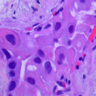

In [378]:
dfTest['backToImage'][4]

In [379]:
imgTestData= np.asarray(dfTest['scaledImage'].tolist())
# imgTestData= np.expand_dims(imgTestData)
imgTestData.shape

(10, 96, 96, 3)

In [380]:
predict_x= pipe.predict(imgTestData)
# classes_x= np.argmax(predict_x, axis=1)
# classes_x= predict_x.argmax(axis= 1)
predict_x

1/1 [==============================] - 0s 92ms/step


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

### Normalize and assign categorical labels

In [75]:
rzImageArr= imageArr/ 255.0

In [76]:
rzImageArr.shape

(25000, 96, 96, 3)

In [77]:
newTarget= to_categorical(targetArr)

In [78]:
newTarget.shape

(25000, 5)

### CNN Model

In [79]:
rzImageArr.shape

(25000, 96, 96, 3)

In [80]:
newTarget.shape

(25000, 5)

In [81]:
rzImageArr.shape[1:]

(96, 96, 3)

In [82]:
%%time
X_train, X_test, y_train, y_test = train_test_split(rzImageArr, newTarget, test_size = 0.3,
                                                    random_state = 65)

CPU times: total: 12.9 s
Wall time: 23.2 s


### Create the model's architecture
- **NOTE ALERT**: Take into account the volume of data and parameters. Time and processing escalate quite fast.
- **NOTE ALERT**: It is likely this data will require more complex models.

In [211]:
# Set up the model architecture
model= Sequential()
model.add(layers.Conv2D(32, (1, 1), activation= 'relu', data_format= 'channels_last',
                        padding= 'valid' ,input_shape= rzImageArr.shape[1:]))
model.add(layers.Conv2D(32, (1, 1), activation= 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation= 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))

In [212]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 96, 96, 32)        128       
                                                                 
 conv2d_42 (Conv2D)          (None, 96, 96, 32)        1056      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 21, 21, 64)      

In [213]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [214]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 96, 96, 32)        128       
                                                                 
 conv2d_42 (Conv2D)          (None, 96, 96, 32)        1056      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 21, 21, 64)      

### Complie the model

In [215]:
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
    metrics=['accuracy'])

### Fit the training data

In [216]:
X_train.shape

(17500, 96, 96, 3)

In [217]:
y_train.shape

(17500, 5)

In [218]:
%%time
# Fit the model on a training set
history = model.fit(
    X_train,
    y_train,
    validation_split = 0.3,
#     validation_data=(X2_test, y2_test),
    epochs = 10,
    batch_size = 10,
    verbose = 1)

Epoch 1/10
1225/1225 [==============================] - 113s 92ms/step - loss: 0.7696 - accuracy: 0.6082 - val_loss: 0.5239 - val_accuracy: 0.7718
Epoch 2/10
1225/1225 [==============================] - 116s 95ms/step - loss: 0.4541 - accuracy: 0.8082 - val_loss: 0.3573 - val_accuracy: 0.8451
Epoch 3/10
1225/1225 [==============================] - 128s 105ms/step - loss: 0.3081 - accuracy: 0.8805 - val_loss: 0.2412 - val_accuracy: 0.9088
Epoch 4/10
1225/1225 [==============================] - 131s 107ms/step - loss: 0.2400 - accuracy: 0.9109 - val_loss: 0.1526 - val_accuracy: 0.9415
Epoch 5/10
1225/1225 [==============================] - 131s 107ms/step - loss: 0.1932 - accuracy: 0.9269 - val_loss: 0.1200 - val_accuracy: 0.9535
Epoch 6/10
1225/1225 [==============================] - 134s 109ms/step - loss: 0.1596 - accuracy: 0.9405 - val_loss: 0.1315 - val_accuracy: 0.9545
Epoch 7/10
1225/1225 [==============================] - 132s 108ms/step - loss: 0.1414 - accuracy: 0.9487 - val_lo

In [219]:
model.save('model.h5')

### Create Predictions

In [220]:
X_test.shape

(7500, 96, 96, 3)

In [355]:
%%time
# predictions = model.predict_classes(X_test)
predict_x= model.predict(X_test)
# classes_x= np.argmax(predict_x, axis=1)
classes_x= predict_x.argmax(axis= 1)

235/235 [==============================] - 13s 56ms/step
CPU times: total: 1min 12s
Wall time: 13.4 s


In [356]:
predArr= model.predict(imgTestData).argmax(axis= 1)

1/1 [==============================] - 0s 35ms/step


In [357]:
classes_x

array([4, 3, 1, ..., 2, 3, 3], dtype=int64)

In [358]:
predArr

array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1], dtype=int64)

In [284]:
X_test.shape

(7500, 96, 96, 3)

In [231]:
y_test.shape

(7500, 5)

### Evaluate the model

In [232]:
%%time
score = model.evaluate(X_test, y_test, batch_size = 10)
print('\nTest loss: %.6f, Test accuracy: %.6f' % tuple(score))

750/750 [==============================] - 15s 20ms/step - loss: 0.0938 - accuracy: 0.9653

Test loss: 0.093771, Test accuracy: 0.965333
CPU times: total: 1min 11s
Wall time: 15.3 s


In [233]:
predArr.shape

(10,)

In [234]:
classes_x.shape

(7500,)

In [235]:
y_test.shape

(7500, 5)

In [236]:
y_test.shape

(7500, 5)

In [237]:
def print_cm(cm):
    d_size = max(len('%d' % cm.max()), len('%d' % cm.shape[1]))
    if min(cm.shape) > 10: # make sparse
        print('Sparse Matrix (*=diagonal)')
        fmt_r = 'r%%0%dd' % d_size
        fmt_c = ', c%%0%dd%%s= %%%dd' % (d_size, d_size)
        for i in range(cm.shape[0]):
            s = fmt_r % i
            for j in range(cm.shape[1]):
                if cm[i, j] > 0:
                    s += fmt_c % (j, '*' if i == j else ' ', cm[i, j])
            print(s)
    else: # make dense
        c = '%%%dd ' % d_size
        s = '%s| ' % (' ' * d_size)
        s += ''.join([c % i for i in range(len(cm[0]))])
        print(s)
        print('-' * len(s))
        for i, r in enumerate(cm):
            s = '%2d| ' % i
            s += c * len(r)
            print(s % tuple(r))

Image Labels:
- Lung benign tissue: 3
- Lung adenocarcinoma: 2
- Lung squamous cell carcinoma: 4
- Colon adenocarcinoma: 0
- Colon benign tissue: 1

In [238]:
y_test_target = np.array([x.argmax() for x in y_test])
cm = confusion_matrix(y_test_target, classes_x)
print_cm(cm)

    |    0    1    2    3    4 
-------------------------------
 0| 1470   28    0    0    0 
 1|   19 1506    0    0    0 
 2|    6    0 1304    9  148 
 3|    0    0   11 1473    0 
 4|    2    0   37    0 1487 


### Visualisation of cost

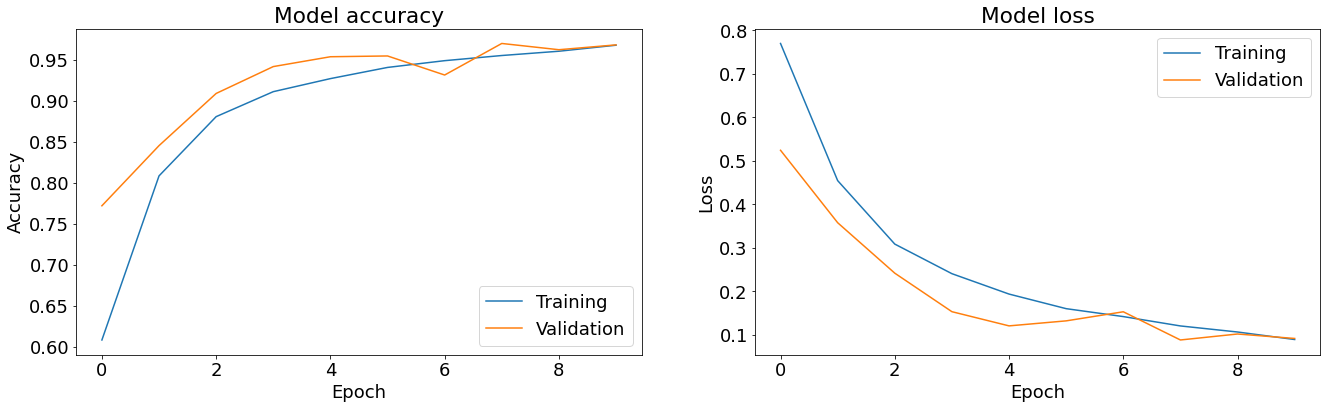

In [239]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 18})

# Plot training & validation accuracy values
ax[0].plot(history.history['accuracy'], label = 'Training')
ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

# Plot training & validation loss values
ax[1].plot(history.history['loss'], label = 'Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

plt.show()